# Customer Churn

# OBJECTIVE

1. Customer Churn & Retention Analysis
2. Customer Churn Categorization
3. Customer Churn prediction for customer that have 1 transaction of all time

# IMPORT PACKAGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import DateOffset
import datetime

# CALLING DATASET

In [2]:
path_dataset = "../phillip morris case code/retail_transaction_data.csv"
df = pd.read_csv(path_dataset)
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# DATA QUALITY CHECK

## DATA TYPE

In [3]:
## DATATYPE CHECK
df.dtypes

order_id                object
product_id              object
product_description     object
quantity                 int64
order_date              object
unit_price             float64
customer_id            float64
country                 object
dtype: object

In [4]:
## CHANGE DATATYPE
### customer_id --> string
### order_date --> Timestamp

df['customer_id'] = df['customer_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['customer_id'] = np.where(df['customer_id']=='nan', np.nan, df['customer_id'])

In [5]:
df.dtypes

order_id                       object
product_id                     object
product_description            object
quantity                        int64
order_date             datetime64[ns]
unit_price                    float64
customer_id                    object
country                        object
dtype: object

## NULL VALUES

In [6]:
df.isnull().sum()

order_id                    0
product_id                  0
product_description      4382
quantity                    0
order_date                  0
unit_price                  0
customer_id            243007
country                     0
dtype: int64

In [7]:
df[df['customer_id'].isnull()]

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066998,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [8]:
# aaa

## DATA DESCRIBE

In [9]:
df.describe()

,quantity,order_date,unit_price
count,1.067371e+06,1067371,1.067371e+06
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04
std,1.727058e+02,NaN,1.235531e+02


Quantity & unit_price have < 0 value

## ORDER CANCEL

In [10]:
df['order_status'] = np.where(df['order_id'].str.startswith('C'), 'CANCEL', 'SALE')

In [11]:
df_os = df.groupby('order_status').agg({'order_id':'nunique'}).reset_index()
df_os['%'] = (df_os['order_id']/df_os['order_id'].sum())*100
df_os

,order_status,order_id,%
0,CANCEL,8292,15.462072
1,SALE,45336,84.537928


# DATASET PREPARATION

- FILTERING
  - exclude order cancel (focused on transaction that generated value)
  - exclude quantity =< 0
  - exclude unit_price =< 0
- ADD COLUMNS
  - Revenue = `quantity` * `unit_price`
  - year_order = Truncate Year of `order_date`
  - year_quarter_order = Truncate Year & Quarter of `order_date`
  - year_month_order = Truncate Year & month `order_date`

In [12]:
## FILTER
df = df[df['order_status'] == 'SALE']
df = df[df['quantity'] > 0]
df = df[df['unit_price'] > 0]
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE


In [13]:
## ADD COLUMNS
df['revenue'] = df['quantity'] * df['unit_price']
df['year_order'] = df['order_date'].dt.year
df['month_order'] = df['order_date'].dt.month
df['year_quarter_order'] = df['order_date'].dt.to_period('Q').dt.to_timestamp()
df['year_month_order'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
df['order_date_day'] = df['order_date'].dt.to_period('D').dt.to_timestamp()
df['quarter'] = pd.PeriodIndex(df['order_date'], freq='Q').astype('str')
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status,revenue,year_order,month_order,year_quarter_order,year_month_order,order_date_day,quarter
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE,83.4,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE,100.8,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE,30.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4


In [14]:
df.dtypes

order_id                       object
product_id                     object
product_description            object
quantity                        int64
order_date             datetime64[ns]
unit_price                    float64
customer_id                    object
country                        object
order_status                   object
revenue                       float64
year_order                      int32
month_order                     int32
year_quarter_order     datetime64[ns]
year_month_order       datetime64[ns]
order_date_day         datetime64[ns]
quarter                        object
dtype: object

# EDA (Explanatory Data Analysis)

__MAIN METRICS__ :

1. __Number of customer__ 
2. __Number of Transaction__
3. __Customer Retention__
   - Cohort analysis
4. __Days between Orders__

In [15]:
## Dataset 
df_monthly = df.groupby('year_month_order').agg({'revenue':'sum', 'quantity':'sum'
                                                , 'customer_id':'nunique'
                                                , 'order_id' : 'nunique'
                                                 , 'unit_price': 'median'}).reset_index().rename(
                                                columns={
                                                    'customer_id':'n_customer', 'order_id' : 'n_order'})
df_quarterly = df.groupby('year_quarter_order').agg({
                                                    'revenue':'sum', 'quantity':'sum'
                                                    , 'customer_id':'nunique', 'unit_price': 'median'
                                                    , 'order_id' : 'nunique'
                                                }
                                                ).reset_index().rename(columns={
                                                    'customer_id':'n_customer', 'order_id' : 'n_order'})

In [16]:
df_monthly.head()

,year_month_order,revenue,quantity,n_customer,n_order,unit_price
0,2009-12-01,825685.760,426981,955,1682,2.57
1,2010-01-01,652708.502,391525,720,1105,2.51
2,2010-02-01,553339.736,382781,772,1201,2.10
3,2010-03-01,833570.131,527401,1057,1681,2.10
4,2010-04-01,681528.992,368198,942,1462,2.10


## Monthly Number of Customer & Number of Transaction per month

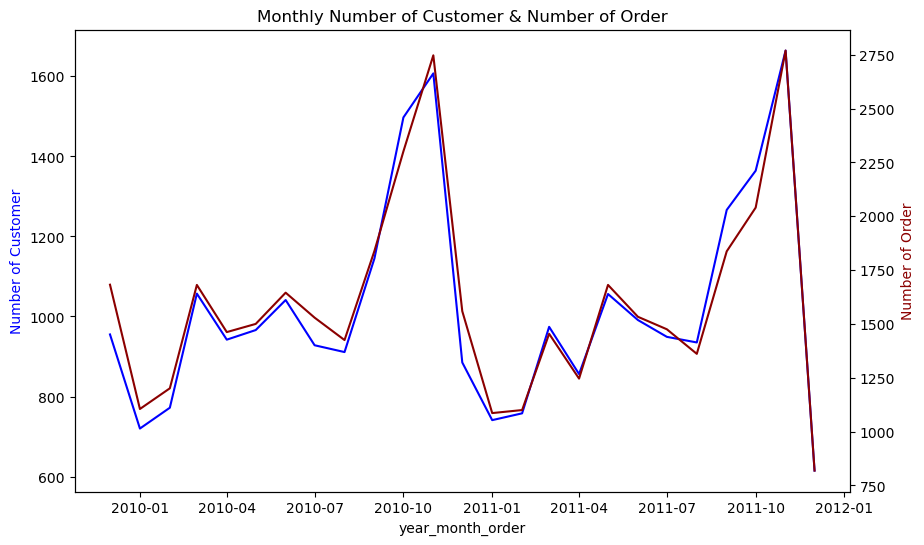

In [17]:
fig1, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_monthly, x='year_month_order', y='n_customer', ax=ax1, color='blue')
ax1.set_ylabel('Number of Customer', color='blue')

ax2=ax1.twinx()
sns.lineplot(data=df_monthly, x='year_month_order', y='n_order', ax=ax2, color='darkred')
ax2.set_ylabel('Number of Order', color='darkred')

plt.title('Monthly Number of Customer & Number of Order')
plt.show()

In [18]:
df_quarterly['growth_n_customer'] = df_quarterly['n_customer'].pct_change()
df_quarterly['growth_n_order'] = df_quarterly['n_order'].pct_change()

df_quarterly[df_quarterly['year_quarter_order'].astype('str').isin(['2010-07-01', '2010-10-01', '2011-07-01', '2011-10-01'])][['year_quarter_order', 'n_customer', 'n_order', 'growth_n_customer', 'growth_n_order']]

,year_quarter_order,n_customer,n_order,growth_n_customer,growth_n_order
3,2010-07-01,2060,4793,0.006351,0.040373
4,2010-10-01,2670,6607,0.296117,0.378469
7,2011-07-01,2161,4673,0.085384,0.047758
8,2011-10-01,2560,5628,0.184637,0.204366


__INSIGHT__

- Number of Customer align with number of Order on every month, when the number of Customer increase, the number of order also increase in certain month
- Number of Customer & Order Always increase Significantly on Q4 in every year (i.e. growth_n_customer in Q4 2010 = 30% & growth_n_order Q4 2010 = 38%), Possibly because of Holiday Season (New Year & Christmas) so People go shopping more often

## Customer Retention Cohort

Use data from 2010-2011

In [19]:
df1 = df[
            (df['year_month_order'] >= '2010-01-01') & (~df['customer_id'].isnull())]\
    [['year_month_order', 'year_order', 'month_order','customer_id']].drop_duplicates()
df1['month_index'] = (((df1['year_order'] - df1['year_order'].min())*12) +(df1['month_order'] - df1['month_order'].min()))

df_cm = df1.groupby('customer_id').agg({'month_index':'min'}).rename(columns= {'month_index' : 'cohort_month'}).reset_index()

df1 = pd.merge(df1, df_cm, how='left', on='customer_id')
df1['cohort_index'] = df1['month_index'] - df1['cohort_month']

df_cohort_raw = df1[['customer_id', 'cohort_month', 'cohort_index']].drop_duplicates()
df_cohort_raw = df_cohort_raw.groupby(['cohort_month', 'cohort_index']).agg({'customer_id':'count'}).rename(columns={'customer_id': 'n_customer'}).reset_index()

df_cohort = df_cohort_raw.pivot_table(index='cohort_month', columns='cohort_index', values='n_customer')
df_cohort = df_cohort.divide(df_cohort.iloc[:, 0], axis=0).round(3)*100

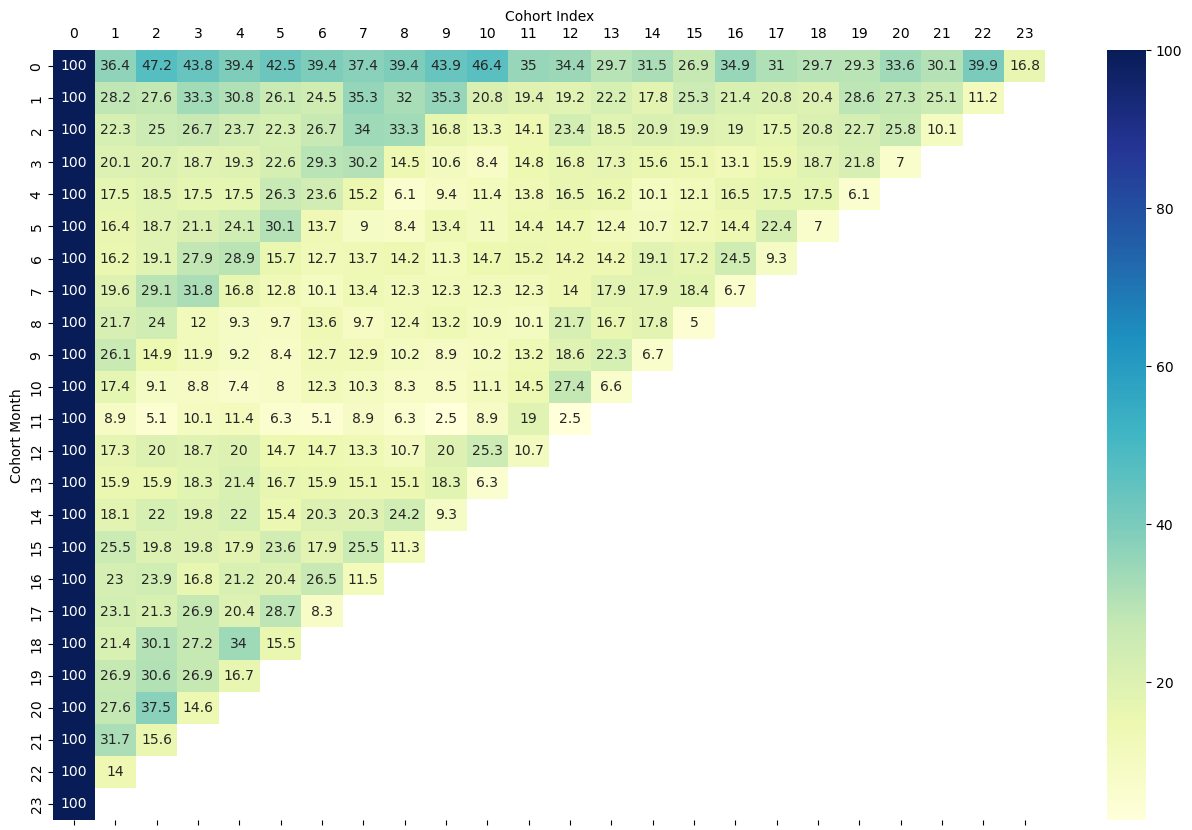

In [20]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

sns.heatmap(df_cohort, annot=True, cmap='YlGnBu', fmt='g')

ax.set_xlabel('Cohort Index')
ax.set_ylabel('Cohort Month')
ax.xaxis.set_label_position('top')
ax.tick_params(labeltop=True, labelbottom=False)


plt.show()

__INSIGHT__ : 

- Most of customer after first transaction, not purchased again in the next month, maximum only 36.4% customer that will re-purchase again in the next month (for customer that the first transaction on 2010-01-01)
- Customers with first transaction on 2010-01-01 tend to increase from 2010-02-01 to 2010-10-01 (36.4% until 46.4%), decrease after that and increase again significantly on 2011-11-01 with value almost 40%
- Customers with first transaction on 2010-12-01 have bad cohort monthly tend to always below 10% (except on 2012-11-01 with value 19%) 

## Days Between 2 Consecutive Order per Customer Distribution 

In [21]:
df.head()

,order_id,product_id,product_description,quantity,order_date,unit_price,customer_id,country,order_status,revenue,year_order,month_order,year_quarter_order,year_month_order,order_date_day,quarter
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,SALE,83.4,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,SALE,81.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,SALE,100.8,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,SALE,30.0,2009,12,2009-10-01,2009-12-01,2009-12-01,2009Q4


In [22]:
df_daily = df.groupby([
                        'order_id', 'order_date_day', 'year_month_order'
                        , 'customer_id']).agg(
                        {'quantity':'sum', 'revenue':'sum'}).reset_index()
df_daily['rank_order'] = df_daily.sort_values('order_date_day', ascending=True).groupby('customer_id').cumcount()+1
df_daily['rank_order_prev'] = df_daily['rank_order'] - 1
df_daily = pd.merge(
                    df_daily
                    , df_daily[['rank_order', 'order_id', 'customer_id', 'order_date_day']]
                    , how = 'left'
                    , left_on = ['rank_order_prev', 'customer_id']
                    , right_on = ['rank_order', 'customer_id']
            ).drop(columns=['rank_order_prev', 'rank_order_y']).rename(columns={
                'order_id_y':'prev_order_id'
                ,'order_date_day_y' : 'prev_order_date_day'
                , 'order_id_x' : 'order_id'
                , 'order_date_day_x' : 'order_date_day'
                , 'rank_order_x' : 'rank_order'
            })
df_daily['days_between_order'] = (df_daily['order_date_day'] - df_daily['prev_order_date_day']).dt.days

MIN : 0.0
MAX : 714.0
MEDIAN : 25.0
MEAN : 51.6872406805828


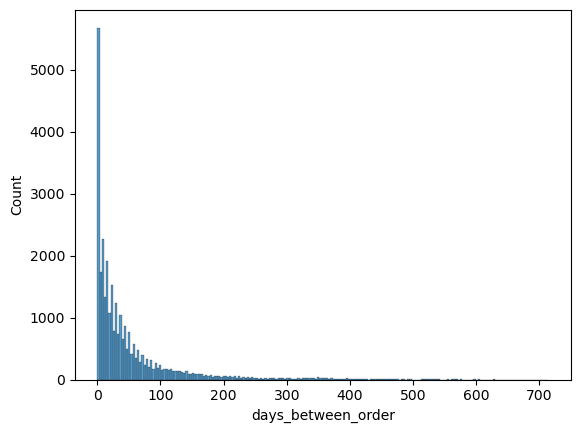

In [23]:
sns.histplot(df_daily['days_between_order'])

print('MIN : {}'.format(df_daily['days_between_order'].min()))
print('MAX : {}'.format(df_daily['days_between_order'].max()))
print('MEDIAN : {}'.format(df_daily['days_between_order'].median()))
print('MEAN : {}'.format(df_daily['days_between_order'].mean()))
# print(df_daily['days_between_order'].mod())

__INSIGHT__: 

- Days between 2 consecutive orders per customer have left skewed, median = 25 days & mean = 51.7 days
- above 100 days have lower frequency
- based on this distribution we can assume that customer that repurchased > 50 days can be classified as churn customer 

## Number of Customer per Count Order

In [24]:
df_cust_group = df_daily.groupby('customer_id').agg({'order_id' : 'nunique'}).reset_index().rename(columns={'order_id':'n_order'})

MIN : 1
MAX : 398
MEDIAN : 3.0
MEAN : 6.289384144266758


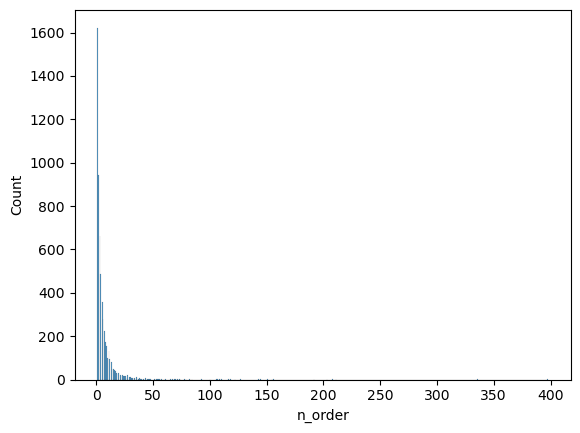

In [25]:
sns.histplot(df_cust_group['n_order'])

print('MIN : {}'.format(df_cust_group['n_order'].min()))
print('MAX : {}'.format(df_cust_group['n_order'].max()))
print('MEDIAN : {}'.format(df_cust_group['n_order'].median()))
print('MEAN : {}'.format(df_cust_group['n_order'].mean()))
# print(df_daily['days_between_order'].mod())

In [26]:
df_n_order = df_cust_group.groupby('n_order').agg({'customer_id':'nunique'}).reset_index().rename(columns={'customer_id':'n_customer'})

display(df_n_order.sort_values('n_customer', ascending=False))
print(pd.merge(df_daily, df_cust_group[df_cust_group['n_order']==1], how='inner', on='customer_id')['order_date_day'].max())

,n_order,n_customer
0,1,1623
1,2,944
2,3,664
3,4,486
4,5,360
...,...,...
66,79,1
67,82,1
68,84,1
69,93,1


2011-12-09 00:00:00


__INSIGHT__ : 

- number of order per customer have distribution left skewed
- Customer that only have 1,2,3 order of all time are dominated with value 1623, 944 and 664 customers each
- customer that only have 1 order would be excluded for models, but would be predicted the churn category after the model completed 

## Customer Churn 

Exclude the customer that only have 1 Order & the first order order from all customer because there is no delta days

__CATEGORIZING CHURN__

- 0-50 days : __Non Churn Customer__
- '>' 50 days : __Churn Customer__

Categorizing churn would have 2 ways : 
1. categorizing directly from days between 2 consecutive order per customer
2. average-ing the days first than categorizing

using the method 2 because method 1 have possibility that churn categoru would not Mutually Exclusive per customer

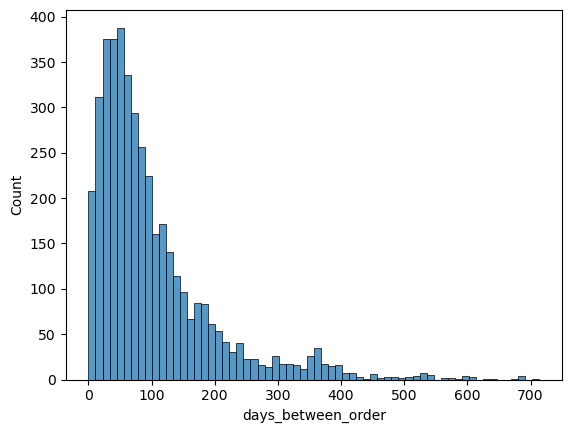

In [27]:
df_churn_cat_raw = df_daily[df_daily['rank_order']>1]

df_cat_churn = df_churn_cat_raw.groupby('customer_id').agg({'days_between_order':'mean'}).reset_index()
df_cat_churn['churn_cat'] = np.where(df_cat_churn['days_between_order'] <= 50, 'Non Churn Customer', 'Churn Customer')

sns.histplot(df_cat_churn['days_between_order'])
plt.show()

In [28]:
df_cat_churn.groupby('churn_cat').agg({'customer_id':'nunique'})

,customer_id
churn_cat,
Churn Customer,2809
Non Churn Customer,1446


### Monthly Number of Customer per Churn Category

In [29]:
df_churn = pd.merge(df, df_cat_churn, how='left', on='customer_id').drop(columns=['days_between_order'])
df_churn['churn_cat'] = df_churn['churn_cat'].fillna('One Time Order')
# df_cat_churn
# df.head()

In [30]:
# df_cek = df_churn[df_churn['churn_cat']=='One Time Order'].groupby('customer_id').agg({'order_id': 'nunique'}).reset_index()
# df_cek[df_cek['order_id']>1]

In [31]:
## Dataset 
df_churn_monthly = df_churn.groupby(['year_month_order', 'churn_cat']).agg({'revenue':'sum', 'quantity':'sum'
                                                , 'customer_id':'nunique'
                                                , 'order_id' : 'nunique'
                                                 , 'unit_price': 'median'}).reset_index().rename(
                                                columns={
                                                    'customer_id':'n_customer', 'order_id' : 'n_order'})
df_churn_quarterly = df_churn.groupby(['year_month_order', 'churn_cat']).agg({
                                                    'revenue':'sum', 'quantity':'sum'
                                                    , 'customer_id':'nunique', 'unit_price': 'median'
                                                    , 'order_id' : 'nunique'
                                                }
                                                ).reset_index().rename(columns={
                                                    'customer_id':'n_customer', 'order_id' : 'n_order'})

<Axes: xlabel='year_month_order', ylabel='n_customer'>

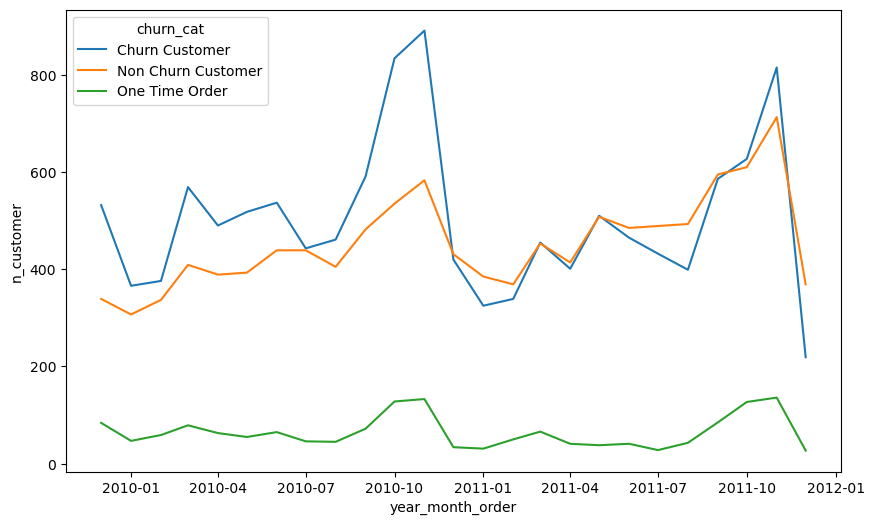

In [32]:
plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_churn_monthly, x='year_month_order', y='n_customer', hue='churn_cat')

__INSIGHT__: 

- Churn Customer have the highest number in every month compared to non churn customer until end of the 2010, from the beginnig of 2011 until 2011-09-01, non churn customers are dominating but end of the year 2011 churn customer dominating again.
- Churn Customers always in have the highest number on the end of the year 2010 & 2011 up to 800-ish customers, possibly they are only purchased for holliday season needs
- Customer that only purchased one time of all time have the lowest number every month compared to other category. also have the highest number on every end of the year 2010 & 2011 (not significant)

### Proprtion Number of Customer per Churn Category

In [33]:
df_churn_prop = df_churn.groupby('churn_cat').agg({'customer_id':'nunique'}).reset_index()

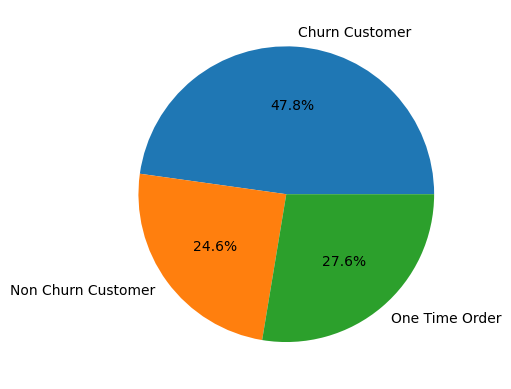

,churn_cat,customer_id
0,Churn Customer,2809
1,Non Churn Customer,1446
2,One Time Order,1623


In [34]:
plt.pie(df_churn_prop['customer_id'], labels=df_churn_prop['churn_cat'], autopct='%1.1f%%')
plt.show()

display(df_churn_prop)

__INSIGHT__ : 

- Churn Customer are dominating the population of customer with percentage 47.8% (2809)
- Non Churn Customer have 14.3% from all customer (1446 customers)

### CHURN CUSTOMER PER COUNTRY

In [35]:
# ## CHECKING relation customer & country
# df_cek = df_churn[['customer_id', 'churn_cat', 'country']].drop_duplicates()
# df_cek_agg = df_cek.groupby(['customer_id', 'churn_cat']).agg({'country' : 'nunique'}).reset_index()

# # df_cek_agg[(df_cek_agg['country']>1)]

# df_churn[df_churn['customer_id']=='12370.0'].groupby(['customer_id', 'country']).agg({'quantity' : 'sum'})

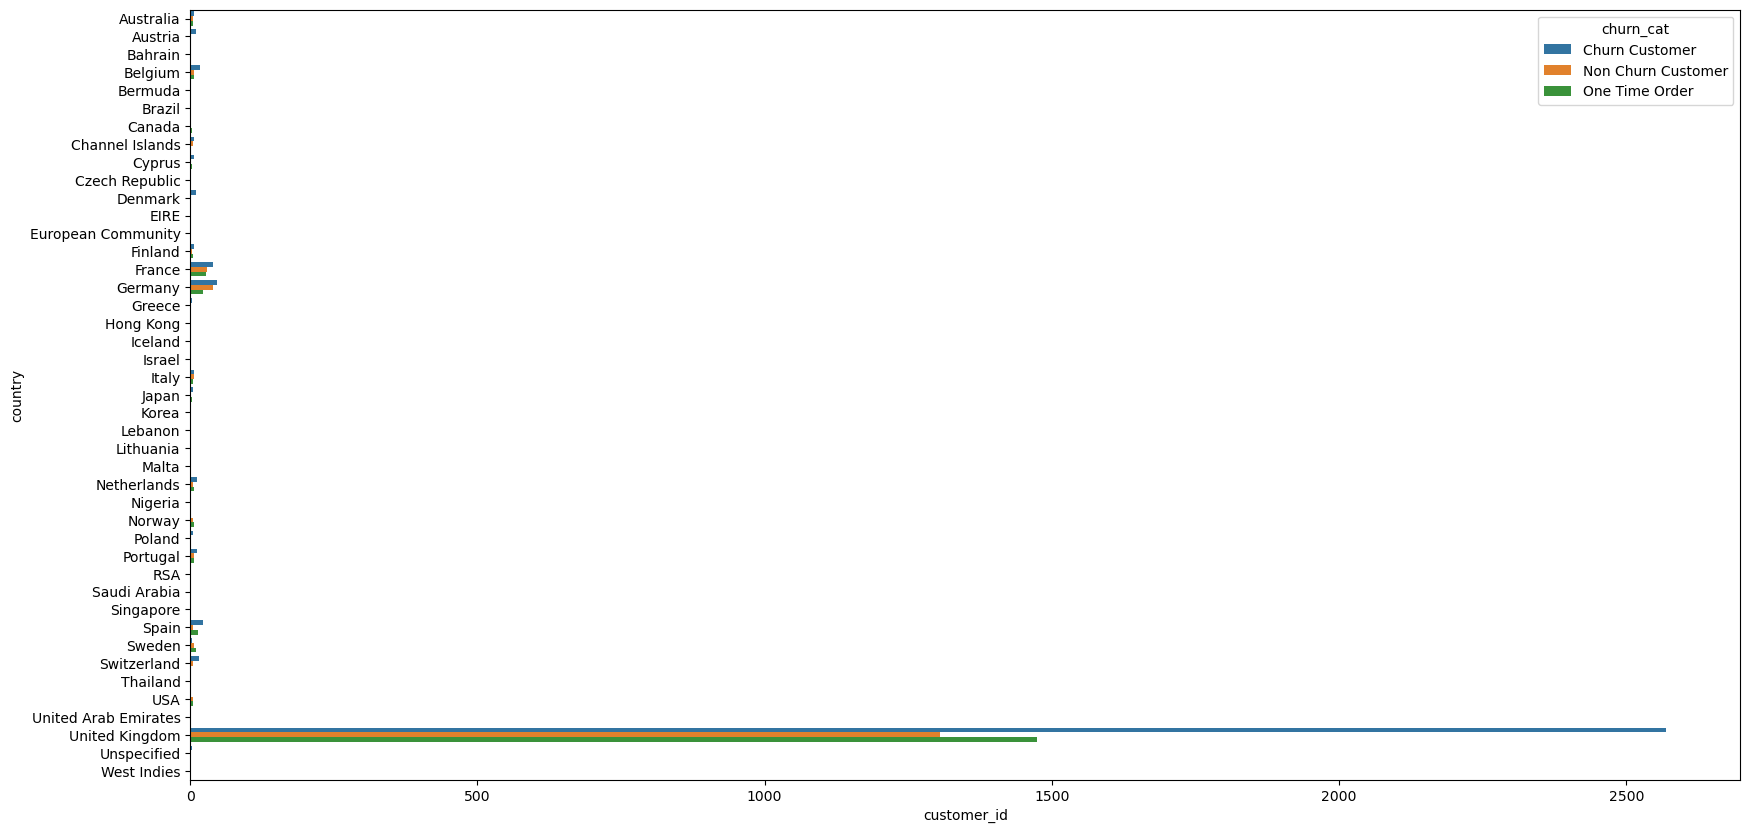

In [36]:
plt.subplots(figsize=(20,10))

sns.barplot(
    data = df_churn.groupby(['country', 'churn_cat']).agg({'customer_id':'nunique'}).reset_index()
    , y='country'
    , x='customer_id'
    , hue='churn_cat'
)
plt.show()

__INSIGHT__ : 

- Number of customers in UK is significantly higher than other countries around 5000 ish customers.
- Number of churn customers in UK are higher, followed by one time order customer and last are non churn customers

## EDA Conclusion

- Number of Customer align with number of Order on every month, when the number of Customer increase, the number of order also increase in certain month
- Number of Customer & Order Always increase Significantly on Q4 in every year (i.e. growth_n_customer in Q4 2010 = 30% & growth_n_order Q4 2010 = 38%), Possibly because of Holiday Season (New Year & Christmas) so People go shopping more often
- Most of customer after first transaction, not purchased again in the next month, maximum only 36.4% customer that will re-purchase again in the next month (for customer that the first transaction on 2010-01-01)
- Customers with first transaction on 2010-01-01 tend to increase from 2010-02-01 to 2010-10-01 (36.4% until 46.4%), decrease after that and increase again significantly on 2011-11-01 with value almost 40%
- Customers with first transaction on 2010-12-01 have bad cohort monthly tend to always below 10% (except on 2012-11-01 with value 19%)
- Days between 2 consecutive orders per customer have left skewed, median = 25 days & mean = 51.7 days
- we can assume that customer that repurchased > 50 days can be classified as churn customer
- Customer that only have 1,2,3 order of all time are dominated with value 1623, 944 and 664 customers each
- customer that only have 1 order would be excluded for models, but would be predicted the churn category after the model completed
- Churn Customer have the highest number in every month compared to non churn customer until end of the 2010, from the beginnig of 2011 until 2011-09-01, non churn customers are dominating but end of the year 2011 churn customer dominating again.
- Churn Customers always in have the highest number on the end of the year 2010 & 2011 up to 800-ish customers, possibly they are only purchased for holliday season needs
- Customer that only purchased one time of all time have the lowest number every month compared to other category. also have the highest number on every end of the year 2010 & 2011 (not significant)
- Churn Customer are dominating the population of customer with percentage 47.8% (2809)
- Non Churn Customer have 14.3% from all customer (1446 customers)
- Number of customers in UK is significantly higher than other countries around 5000 ish customers.
- Number of churn customers in UK are higher, followed by one time order customer and last are non churn customers